In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import re
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns
# Apply the default theme
sns.set_theme()
sns.set_style(style='white')

In [13]:
boxplot_style = {
    "notch": True,
    "flierprops": {"marker": "x"},
    "boxprops": {"facecolor": (.4, .6, .8, .5)},
    "medianprops": {"color": "coral"},
    "width": .5,
    # "orient": "v",
}
onem2m = ['ACME', 'Mobius', 'om2m-mongo']
onem2m_for_pattern = ['ACME', 'mobius', 'om2m-mongo']
request = ['get', 'post']
test = ['emulation', 'stress']
# test = ['emulation', 'pattern','stress']
system = ['real-system', 'fake-system']
system_labels = ['Real Workload', 'Simulated Workload']
labels = ['', 'LD Periodic', 'HD Periodic', 'Step', 'Poisson']
# linestyle_cycler = cycler('color', ['r', 'g', 'b', 'y', 'c', 'k']) * cycler('linestyle', ['-', '--', ':', '-.'])

def read_docker_txt(file_name):
    with open(file_name) as f:
        first_line = f.readline()
        if first_line == '\n':
            first_line = f.readline()
        keys = re.findall(r"(\S*|\S*\s.\s\S*|\S*\s\S*)\s{2,}", first_line)
        first_word = keys[0]
        df = pd.DataFrame(columns=keys)
        line = f.readline()
        while line:
            if not first_word in line:
                match_list = re.findall(r"(\S*|\S*\s.\s\S*)\s{2,}", line)
                df.loc[-1] = match_list
                df.index += 1
            line = f.readline()
    df['CPU % '] = df['CPU % '].apply(
        lambda x: x.replace('%', '')).astype(float)
    df['MEM % '] = df['MEM % '].apply(lambda x: re.match(
        r'(\d*.\d*).*', x).group().replace('%', '')).astype(float)
    # df = df.iloc[::-1]
    # df = df.reindex(index=df.index[::-1])
    df['time'] = (df.index+1)*5
    df['time'] = df['time'].values[::-1]
    return df


def getFilePath(test_type, req_type, onem2m_type, system_type="real-system", pattern=2, file_name="_stats_history.csv"):
    _onem2m_type = onem2m_type
    if test_type == 'pattern':
        _onem2m_type = f"{onem2m_type}/Locust{pattern}"

    final_string = f"../locust_tests/{system_type}/{test_type}/{req_type}/{_onem2m_type}/{file_name}"
    return final_string


def cleanDf(stats_df):
    # Convert timetamp in stats_df to start from 0
    stats_df['Timestamp'] = stats_df['Timestamp'] - stats_df['Timestamp'][0]

    # Find the index where user count first becomes non-zero
    first_non_zero_index = stats_df[stats_df['User Count'] != 0].index.min()

    # Find the index where user count becomes zero again after it became non-zero
    zero_index = stats_df[stats_df.index >
                          first_non_zero_index][stats_df['User Count'] == 0].index.min()

    if not isinstance(zero_index, np.int64):
        zero_index = stats_df.index[-1]

    # remove all rows after the user count became zero again
    stats_df = stats_df[stats_df.index < zero_index]
    # stats_df = stats_df.dropna(subset = ['Total Average Response Time'])
    return stats_df

[Text(207.0, 0.5, 'Total Average Response Time'),
 Text(207.0, 0.5, 'Total Average Response Time'),
 Text(207.0, 0.5, 'Total Average Response Time'),
 Text(207.0, 0.5, 'Total Average Response Time')]

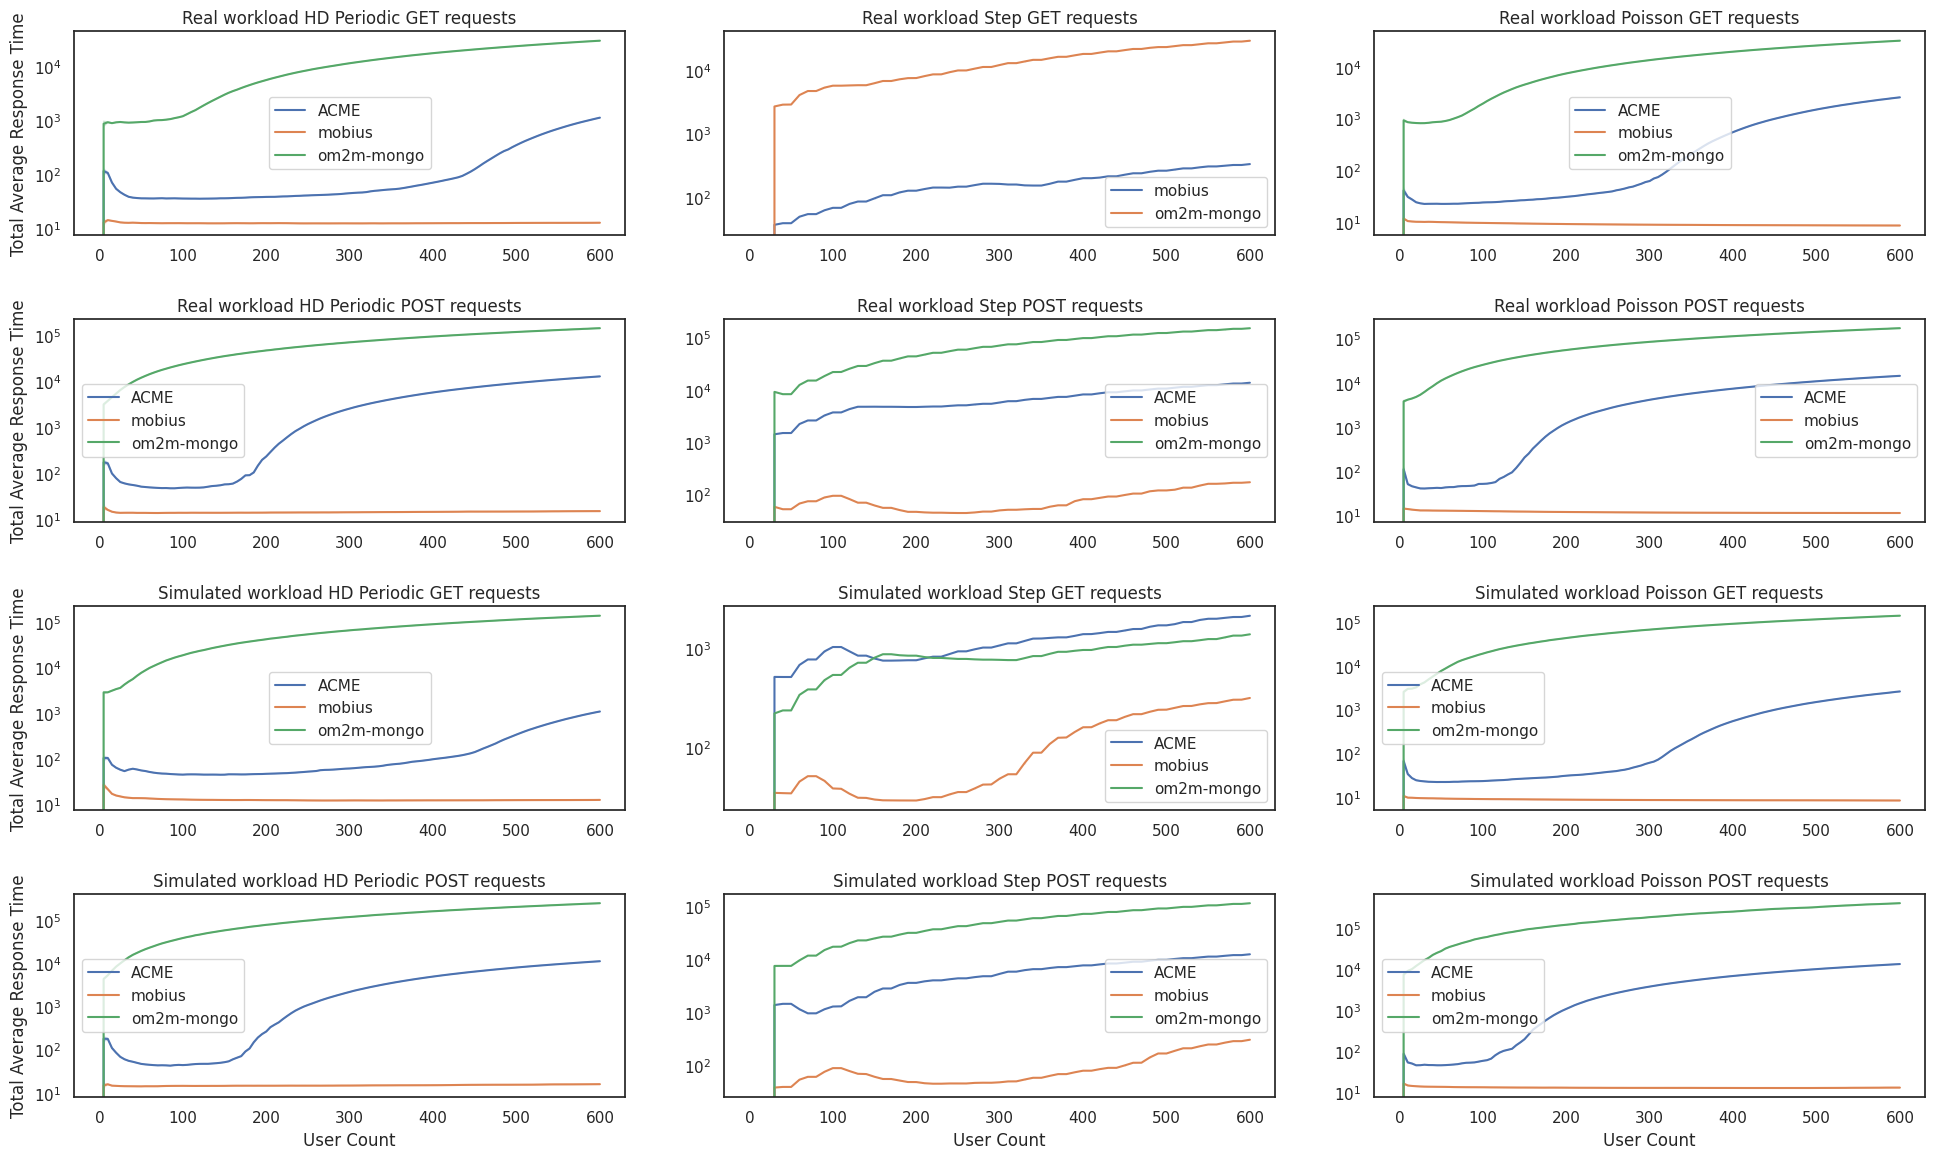

In [3]:
fig, axes = plt.subplots(4, 3, figsize=(20, 12))
# fig.suptitle('Stats')
fig.tight_layout(pad=3.0)
data = pd.DataFrame()
row = 0
col = 0
for system_type in system:
    for req_type in request:
        for pattern in [2, 3, 4]:
            for onem2m_type in onem2m_for_pattern:
                data = cleanDf(pd.read_csv(getFilePath(
                    'pattern', req_type, onem2m_type, system_type, pattern)))
                line_plot = sns.lineplot(
                    data=data,
                    legend='brief', label=f"{onem2m_type}",
                    ax=axes[row % 4, col % 3],
                    x="User Count", y="Total Average Response Time",
                )
                line_plot.set(xlabel=None, ylabel=None,
                          title=f'{system_labels[system.index(system_type)].capitalize()} {labels[pattern]} {req_type.upper()} requests')
            axes[row % 4, col % 3].set_yscale('log')
            col += 1
        row += 1
plt.setp(axes[-1, :], xlabel='User Count')
plt.setp(axes[:, 0], ylabel='Total Average Response Time')


[Text(207.0, 0.5, 'Total Average Response Time'),
 Text(1052.4545454545453, 0.5, 'Total Average Response Time')]

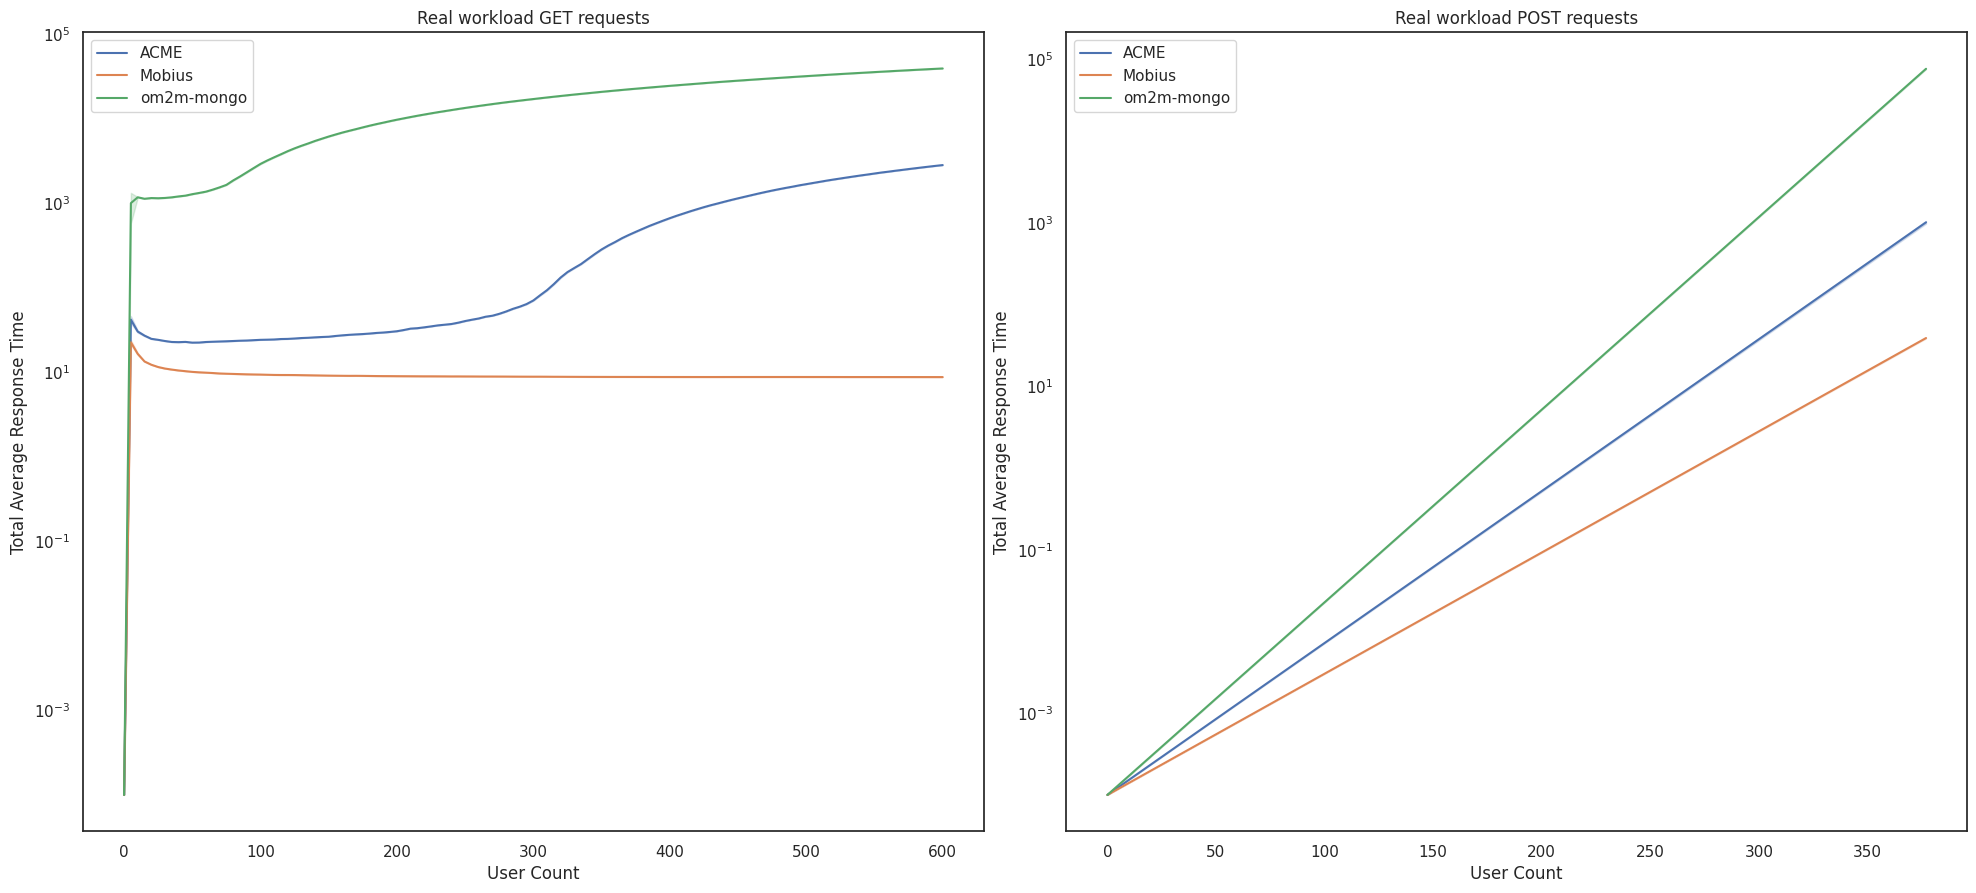

In [4]:
fig, axes = plt.subplots(1,2,figsize=(20, 9))
# fig.suptitle('Stats')
fig.tight_layout(pad=2.0)
row = 0
for req_type in request:
    for onem2m_type in onem2m:
        for test_type in [test[0]]:
            data = cleanDf(pd.read_csv(getFilePath(
                test_type, req_type, onem2m_type)))
            data['Total Average Response Time']=data['Total Average Response Time'].replace(0,0.0001)
            sns.lineplot(
                data=data,
                ax=axes[row],
                x="User Count", y="Total Average Response Time", label=f"{onem2m_type}",
            ).set(xlabel=None, ylabel=None, title=f'{system_labels[0].capitalize()} {req_type.upper()} requests')
            axes[row].set_yscale('log')
    row += 1
# fig.supxlabel('User Count')
# fig.supylabel('Total Average Response Time')
plt.setp(axes[0:], xlabel='User Count')
plt.setp(axes[:], ylabel='Total Average Response Time')

[Text(207.0, 0.5, 'CPU usage %'),
 Text(207.0, 0.5, 'CPU usage %'),
 Text(207.0, 0.5, 'CPU usage %')]

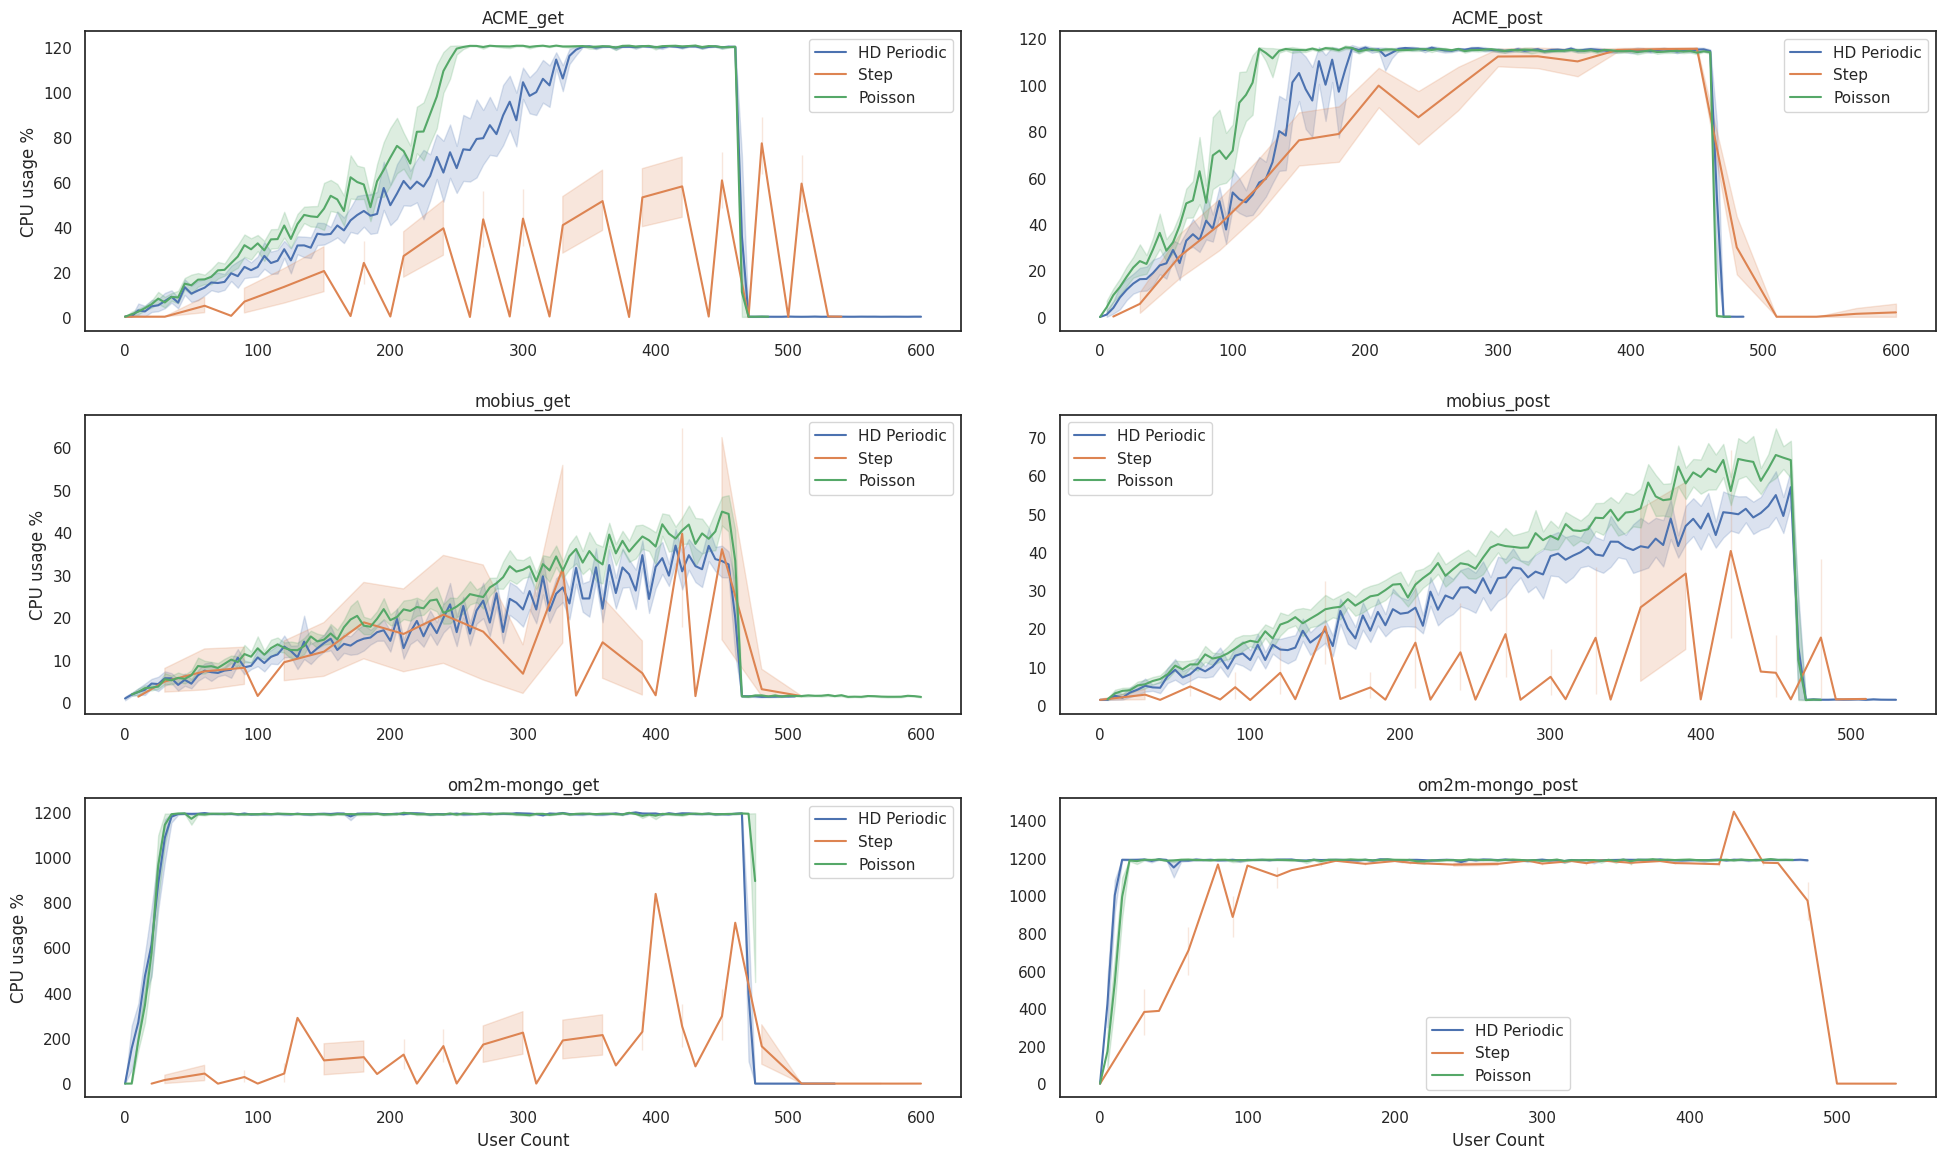

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(20, 12))
# fig.suptitle('Stats')
fig.tight_layout(pad=3.0)
row = 0
col = 0
for onem2m_type in onem2m_for_pattern:
    for req_type in request:
        for pattern in range(2, 5):
            data = cleanDf(pd.read_csv(getFilePath(
                'pattern', req_type, onem2m_type, "fake-system", pattern)))
            docker_data = read_docker_txt(
                getFilePath(
                    'pattern', req_type, onem2m_type, "fake-system", pattern, file_name="docker_stats_output.txt"),
            )
            # merge the two DataFrames on the Timestamp = time
            final_df = pd.merge(data, docker_data, left_on='Timestamp',
                                right_on='time', how='left', suffixes=('', 'ffill'))
            line_plot = sns.lineplot(
                data=final_df,
                legend='brief', label=f"{labels[pattern]}",
                ax=axes[row, col % 2],
                x="User Count", y="CPU % "
            )
        line_plot.set(xlabel=None, ylabel=None,
                      title=f'{onem2m_type}_{req_type}')
        col += 1
    row += 1
plt.setp(axes[-1, :], xlabel='User Count')
plt.setp(axes[:, 0], ylabel='CPU usage %')

[Text(207.0, 0.5, 'CPU usage %'),
 Text(207.0, 0.5, 'CPU usage %'),
 Text(207.0, 0.5, 'CPU usage %')]

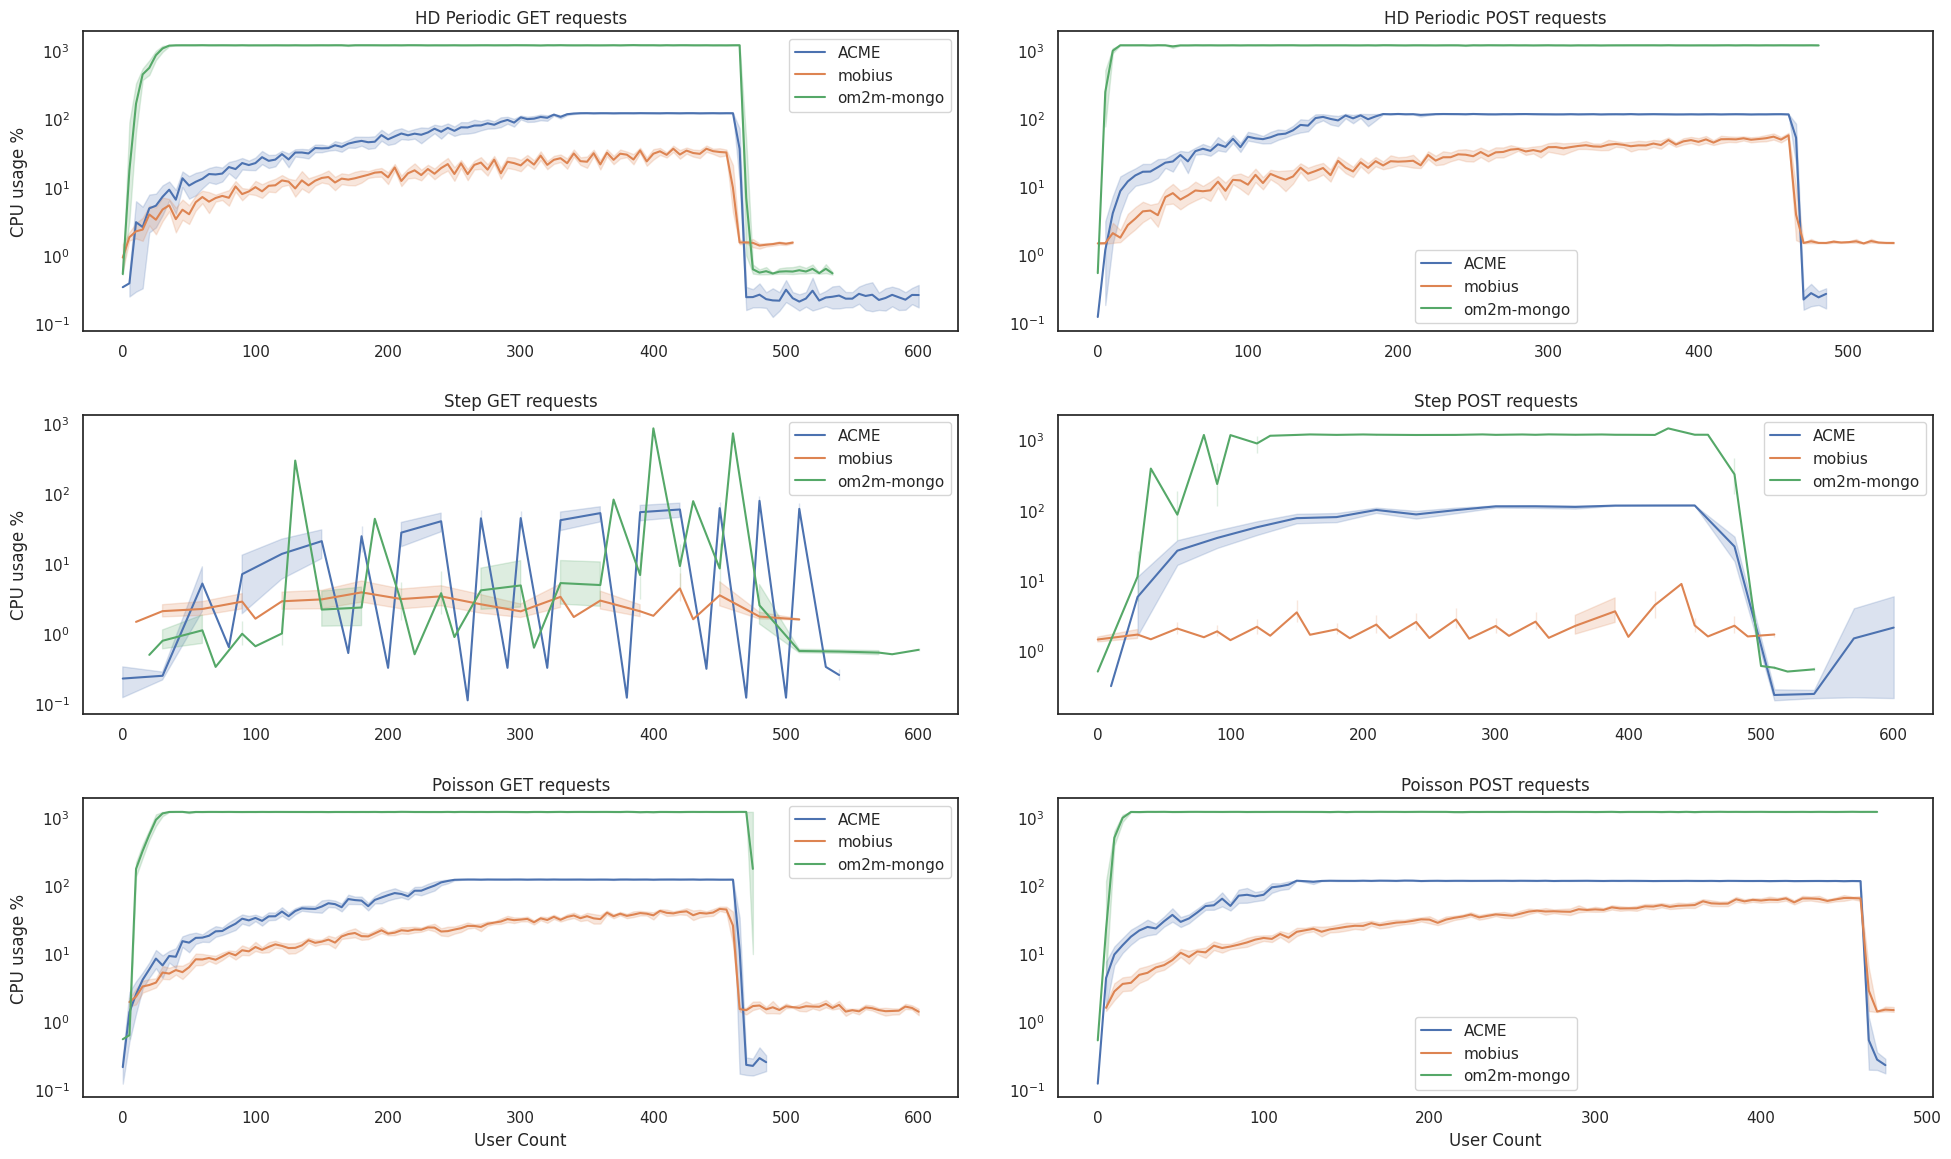

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(20, 12))
# fig.suptitle('Stats')
fig.tight_layout(pad=3.0)
row = 0
col = 0
for pattern in range(2, 5):
    for req_type in request:
        for onem2m_type in onem2m_for_pattern:
            data = cleanDf(pd.read_csv(getFilePath(
                'pattern', req_type, onem2m_type, "fake-system", pattern)))
            docker_data = read_docker_txt(
                getFilePath(
                    'pattern', req_type, onem2m_type, "fake-system", pattern, file_name="docker_stats_output.txt"),
            )
            # merge the two DataFrames on the Timestamp = time
            final_df = pd.merge(data, docker_data, left_on='Timestamp',
                                right_on='time', how='left', suffixes=('', 'ffill'))
            line_plot = sns.lineplot(
                data=final_df,
                legend='brief', label=f"{onem2m_type}",
                ax=axes[row, col % 2],
                x="User Count", y="CPU % "
            )
            axes[row, col % 2].set_yscale('log')
            line_plot.set(xlabel=None, ylabel=None,
                      title=f'{labels[pattern]} {req_type.upper()} requests')
        col += 1
    row += 1
plt.setp(axes[-1, :], xlabel='User Count')
plt.setp(axes[:, 0], ylabel='CPU usage %')

[Text(94.5, 0.5, 'Total Average Response Time'),
 Text(94.5, 0.5, 'Total Average Response Time')]

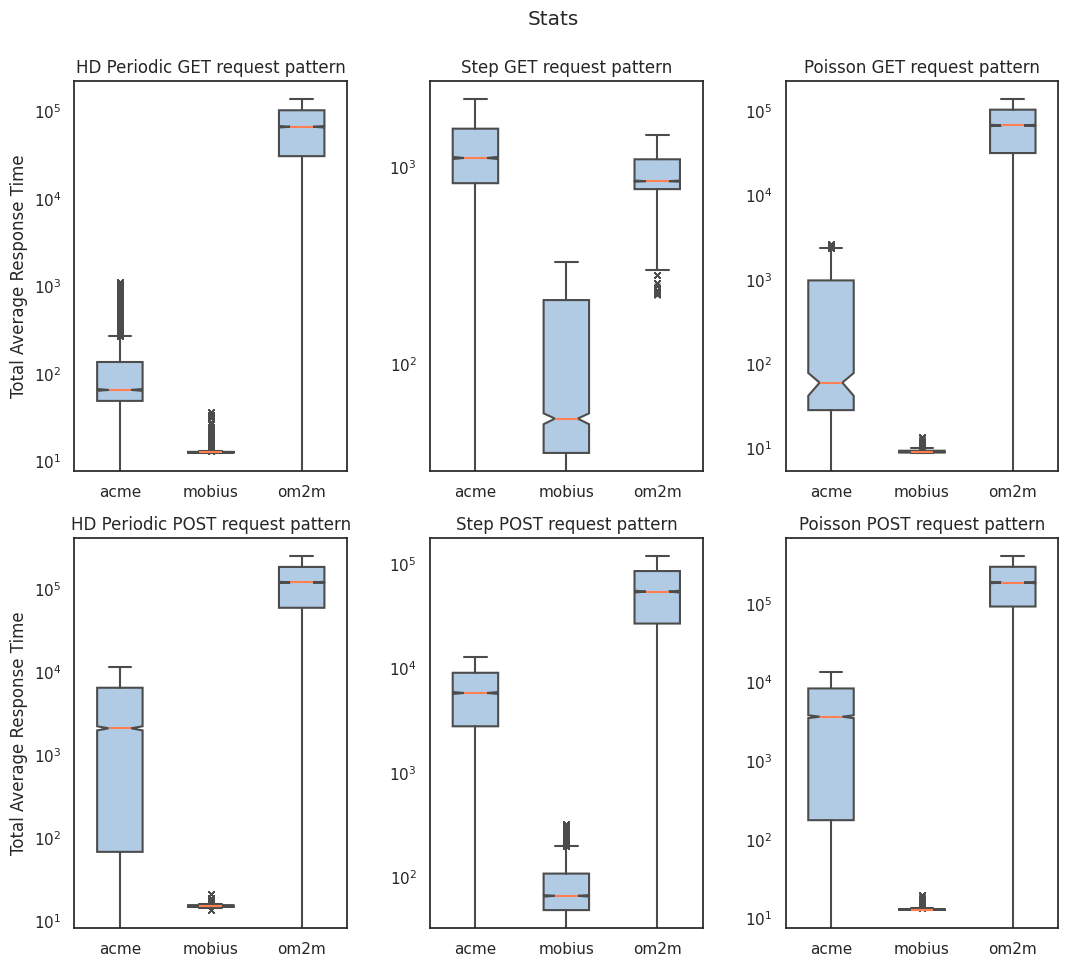

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(11, 10))
fig.suptitle('Stats')
fig.tight_layout(pad=2.0)
row = 0
col = 0
for req_type in request:
    for pattern in [2, 3, 4]:
        data_acme = cleanDf(pd.read_csv(getFilePath(
            'pattern', req_type, onem2m_for_pattern[0], "fake-system", pattern)))
        data_acme['architecture'] = 'acme'
        data_mobius = cleanDf(pd.read_csv(getFilePath(
            'pattern', req_type, onem2m_for_pattern[1], "fake-system", pattern)))
        data_mobius['architecture'] = 'mobius'
        data_om2m = cleanDf(pd.read_csv(getFilePath(
            'pattern', req_type, onem2m_for_pattern[2], "fake-system", pattern)))
        data_om2m['architecture'] = 'om2m'

        # data_join = pd.concat([data_acme, data_mobius])
        data_join = pd.concat([data_acme, data_mobius, data_om2m])
        # print(data_acme_mobius_om2m.keys())
        line_plot = sns.boxplot(
            data=data_join,
            ax=axes[row, col % 3],
            **boxplot_style,
            y="Total Average Response Time", x="architecture"
        ).set(xlabel=None, ylabel=None,
              title=f'{labels[pattern]} {req_type.upper()} request pattern')
        axes[row,col%3].set_yscale('log')
        col += 1
    row += 1
# plt.setp(axes[-1, :], xlabel='User Count')
plt.setp(axes[:, 0], ylabel='Total Average Response Time')

[Text(182.0, 0.5, 'Avg Response Time'),
 Text(182.0, 0.5, 'Avg Response Time'),
 Text(182.0, 0.5, 'Avg Response Time'),
 Text(182.0, 0.5, 'Avg Response Time')]

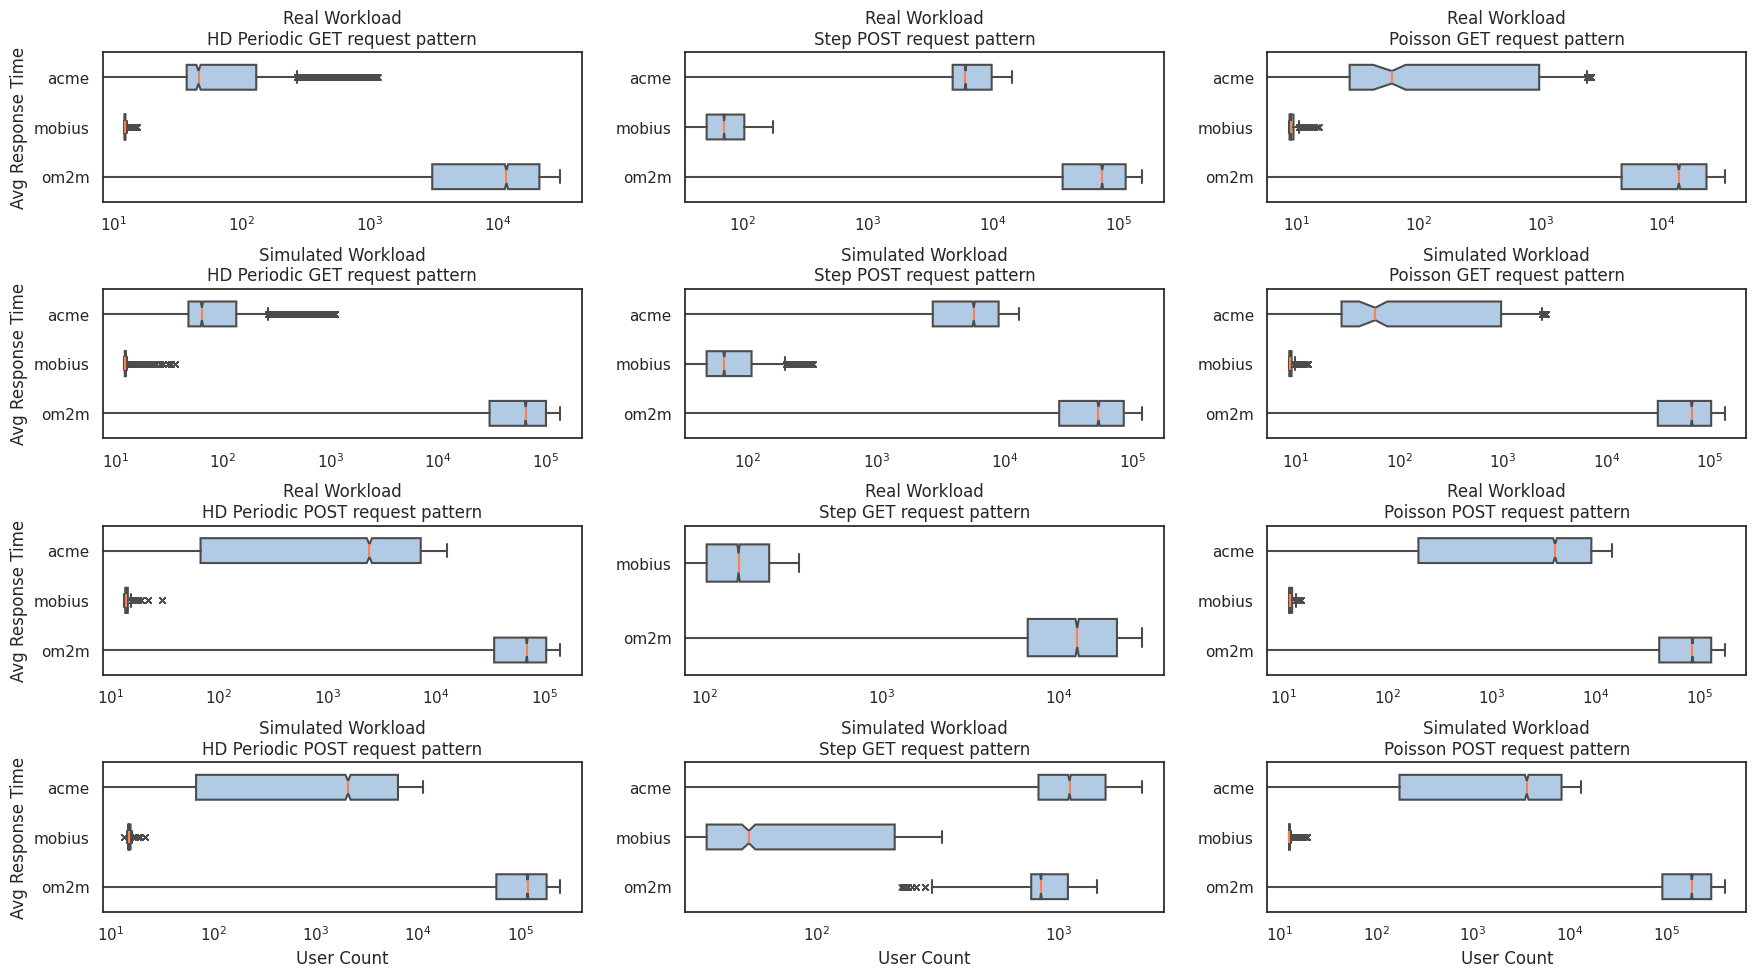

In [11]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))
fig.tight_layout(pad=3.2)
row = 0
col = 0
for req_type in request:
    for pattern in [2, 3, 4]:
        for system_type in system:
            data_acme = cleanDf(pd.read_csv(getFilePath(
                'pattern', req_type, onem2m_for_pattern[0], system_type, pattern)))
            data_acme['architecture'] = 'acme'
            data_mobius = cleanDf(pd.read_csv(getFilePath(
                'pattern', req_type, onem2m_for_pattern[1], system_type, pattern)))
            data_mobius['architecture'] = 'mobius'
            data_om2m = cleanDf(pd.read_csv(getFilePath(
                'pattern', req_type, onem2m_for_pattern[2], system_type, pattern)))
            data_om2m['architecture'] = 'om2m'

            # data_join = pd.concat([data_acme, data_mobius])
            data_join = pd.concat([data_acme, data_mobius, data_om2m])
            line_plot = sns.boxplot(
                data=data_join,
                ax=axes[col%4, row % 3],
                **boxplot_style,
                x="Total Average Response Time", y="architecture"
            ).set(xlabel=None, ylabel=None,
                title=f'{system_labels[system.index(system_type)]}\n{labels[pattern]} {req_type.upper()} request pattern')
            axes[col%4, row % 3].set_xscale('log')
            col += 1
        row += 1
plt.setp(axes[-1, :], xlabel='User Count')
plt.setp(axes[:, 0], ylabel='Avg Response Time')
# fig.supxlabel('\nUser Count')
# fig.supylabel('Total Average Response Time')